In [12]:
from PIL import Image
import matplotlib.pyplot as plt
from google import genai
from google.genai import types
from transformers import pipeline
from IPython.display import Audio as IPythonAudio
import numpy as np
import re
import os
import warnings
from transformers.utils import logging

In [2]:
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

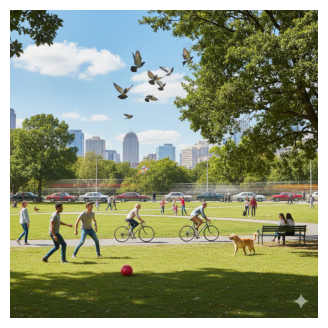

In [3]:
img = Image.open("images/image-test.png")

plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
f = open("keys/gemini.txt")
key = f.read()

client = genai.Client(api_key=key)

In [5]:
NUM_WORDS = {
    "0":"zero","1":"one","2":"two","3":"three","4":"four","5":"five",
    "6":"six","7":"seven","8":"eight","9":"nine","10":"ten"
}

def clean_text(text: str) -> str:
    text = re.sub(r"[*•\-]", " ", text)
    text = re.sub(r"[\[\]{}()]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def numbers_to_words(text: str) -> str:
    for num, word in NUM_WORDS.items():
        text = re.sub(rf"\b{num}\b", word, text)
    return text

def normalize_object_list(text: str) -> str:
    text = re.sub(r"(?i)detected objects?:?", "", text)
    text = text.replace(";", ",")
    text = re.sub(r"\s*,\s*", ", ", text)
    return text.strip()

def limit_length(text: str, max_chars=250) -> str:
    if len(text) <= max_chars:
        return text
    cut = text[:max_chars].rfind(".")
    if cut != -1:
        return text[:cut+1]
    return text[:max_chars]

def prepare_for_tts(text: str) -> str:
    text = clean_text(text)
    text = normalize_object_list(text)
    text = numbers_to_words(text)
    text = limit_length(text)
    if not text.lower().startswith("the image"):
        text = "The image shows " + text

    if not text.endswith("."):
        text += "."
    return text

In [9]:
custom_config = types.GenerateContentConfig(
    system_instruction="""You are a helpful AI Assistant. 
        Given an image perform object detection and provide a text output which 
        contains the information about the labels detected and their counts.
    """,
    temperature=1,
    top_p=0.8,
)

with open('images/image-test.png', 'rb') as f:
  image_bytes = f.read()

context = [
    types.Part.from_bytes(
        data=image_bytes,
        mime_type='image/png',
    ),
]

response = client.models.generate_content(
    model="gemini-3-flash-preview",
    config=custom_config,
    contents=context
)

text = response.text
speech_text = prepare_for_tts(response.text)
print("RAW:\n", raw_caption)
print("\nTTS:\n", speech_text)

RAW:
 I've spotted 24 people, 9 cars, 8 birds, 2 dogs, 2 bicycles, 1 sports ball, 1 bench, and 1 kite in this picture.

TTS:
 The image contains 47 objects: eight birds, 23 persons, nine cars, two bicycles, two dogs, one bench, one sports ball, and one kite.


In [10]:
narrator = pipeline(
    task="text-to-audio",
    model="suno/bark-small"
)

narrated_text = narrator(speech_text)
sampling_rate = narrated_text["sampling_rate"]
audio = np.array(narrated_text["audio"])
if audio.ndim == 2:
    audio = audio.squeeze(0)

print(f"Shape: {audio.shape}, Sampling Rate: {sampling_rate}")

Loading weights:   0%|          | 0/542 [00:00<?, ?it/s]

Shape: (298560,), Sampling Rate: 24000


In [13]:
IPythonAudio(audio, rate=sampling_rate)